In [1]:
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.autonotebook import tqdm
from ml_lib import TBReporter, PandasDataSet
from overloads import CrossEntropyTrainer
import wrapper

In [2]:
class Vector():
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z
    
    def mag(self):
        return math.sqrt(self.mag2())
    
    def mag2(self):
        return self.x**2 + self.y**2 + self.z**2
    
    def unit(self):
        return self/self.mag()
    
    def dot(self, other):
        return self.x*other.x + self.y*other.y + self.z*other.z
    
    def __truediv__(self, val):
        return self*(1./val)
    
    def __mul__(self, val):
        return Vector(self.x*val, self.y*val, self.z*val)
    
    def __rmul__(self, val):
        return Vector(self.x*val, self.y*val, self.z*val)
    
    def __add__(self, other):
        return Vector(self.x+other.x, self.y+other.y, self.z+other.z)
    
    def __sub__(self, other):
        return self + (other*-1)
        
    def __str__(self):
        return "Vector({x},{y},{z})".format(**self.__dict__)

def cda(v1, v2, p1, p2):
    w0 = v1-v2
    
    a = p1.mag2()
    b = p1.dot(p2)
    c = p2.mag2()
    d = p1.dot(w0)
    e = p2.dot(w0)
    
    s = (b*e-c*d)/(a*c-b**2)
    t = (a*e-b*d)/(a*c-b**2)
    
    d1 = (v1+p1*s)
    d2 = (v2+p2*t)
    d = d1-d2
    vtx = d1 + 0.5*d
    
    return str(vtx), d.mag()


def generate_one():
    v1 = Vector(random.uniform(-10, 10), random.uniform(-10, 10), random.uniform(-10, 10))
    v2 = Vector(random.uniform(-10, 10), random.uniform(-10, 10), random.uniform(-10, 10))
    good = random.randint(0,1)

    if good==0:
        out = (0,1)
        p1 = Vector(random.uniform(-10, 10), random.uniform(-10, 10), random.uniform(-10, 10))-v1
        p2 = Vector(random.uniform(-10, 10), random.uniform(-10, 10), random.uniform(-10, 10))-v2
    else:
        out = (1,0)
        vtx = Vector(random.uniform(-10, 10), random.uniform(-10, 10), random.uniform(-10, 10))
        p1 = Vector(random.gauss(vtx.x, 0.5), random.gauss(vtx.y, 0.5), random.gauss(vtx.z, 0.5))-v1
        p2 = Vector(random.gauss(vtx.x, 0.5), random.gauss(vtx.y, 0.5), random.gauss(vtx.z, 0.5))-v2
    
    _, cda_d = cda(v1,v2,p1,p2)
    #print("Real vertex", str(vtx), good)
    #print("Fake vertex", cda(v1, v2, p1, p2))

    return (v1.x, v1.y, v1.z, v2.x, v2.y, v2.z, p1.x, p1.y, p1.z, p2.x, p2.y, p2.z, cda_d), (good)
    #x1 = random.uniform(-10, 10)
    #m = random.uniform(1,10)
    #a = random.uniform(100,200)
    #return (x1, m), (m*x1)

In [3]:
class Track():
    def __init__(self, pos=Vector(), p=Vector(), E=None, m=None):
        self.init_pos = pos
        self.p = p
        if E is None and m is not None:
            self.E = math.sqrt(m**2 + p.mag2())
        elif m is None and E is not None:
            self.E = E
        else:
            self.E = 0
    
    def m2(self):
        return self.E**2-self.p.mag2()
    
    def m(self):
        return math.sqrt(self.m2())
    
    def __str__(self):
        ret =  "Track:\n"
        ret += "  Pos: {init_pos}\n"
        ret += "  P  : {p}\n"
        ret += "  E  : {E}\n"
        ret += "  M  : {0}\n"
        return ret.format(self.m(), **self.__dict__)

class Event():
    def __init__(self):
        self.vertex = None
        self.tracks = []
    
    def to_record(self):
        dret = {"v_{0}".format(k):v for k,v in vars(self.vertex).items()}
        dret.update({"k_p{0}".format(k):v for k,v in vars(self.tracks[0].p).items()})
        dret.update({"k_{0}".format(k):v for k,v in vars(self.tracks[0].init_pos).items()})
        dret.update({"pi_p{0}".format(k):v for k,v in vars(self.tracks[1].p).items()})
        dret.update({"pi_{0}".format(k):v for k,v in vars(self.tracks[1].init_pos).items()})
        return dret
    
def propagate(pos, p, z):
    zdiff = z-pos.z
    return pos + (p.unit()/p.unit().z)*zdiff

def generate2d(number):
    for i in range(number):
        # All units are in mm, MeV
        evt = Event()
        # Generate vertex as gaussian over (x,y)= (0+-10,0+-10) mm with z flat between 110000-180000
        evt.vertex = Vector(random.gauss(0, 10), 0, random.gauss(0, 10))
        # Generate K momentum (gaussian around |p|=75000+-7000MeV, then (px,py) as gaussian around (0+-200, 0+-200)MeV)
        p = random.gauss(75000, 7000)
        px = random.gauss(0, 5000)
        py = 0
        pz = math.sqrt(p**2-px**2-py**2)
        kaon = Track(p=Vector(px,py,pz), m=493.667)
        kaon.init_pos = propagate(evt.vertex, kaon.p, -50)
        evt.tracks.append(kaon)
        # Generate downstream momentum (flat between 15000 and 60000MeV) then (px,py) as gaussian around (0+-1000, 0+-1000)MeV)
        p  = random.uniform(15000, 60000)
        px = random.gauss(p/2., 1000)
        py = 0
        pz = math.sqrt(p**2-px**2)
        dstrack = Track(p=Vector(px, py, pz), m=139.570)
        dstrack.init_pos = propagate(evt.vertex, dstrack.p, 100)
        evt.tracks.append(dstrack)
        
        yield evt

In [4]:
from ml_lib import DrawableNet

class MyNet(DrawableNet):
    def __init__(self):
        super(MyNet, self).__init__()
        self.hidden1 = nn.Linear(13, 20)
        self.output = nn.Linear(20, 2)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        #x = F.sigmoid(self.hidden2(x))
        x = self.output(x)
        return x

In [5]:
data = []
labels = []
for i in range(10000):
    x, vtx = generate_one()
    data.append(x)
    labels.append(vtx)
ds = torch.utils.data.TensorDataset(torch.Tensor(data[:9000]), torch.Tensor(labels[:9000]).long())
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers=4, drop_last=True)
ds = torch.utils.data.TensorDataset(torch.Tensor(data[9000:]), torch.Tensor(labels[9000:]).long())
dl_val = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers=4, drop_last=True)

MyNet(
  (hidden1): Linear(in_features=13, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=2, bias=True)
)
Creating model at test2
  Name: Dummy_model
Saving model in test2/Dummy_model_0/model_Dummy_model_0.pth


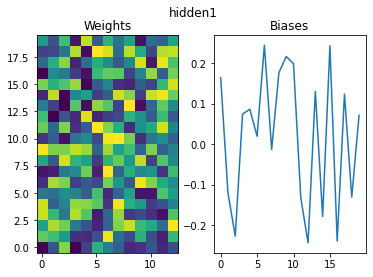

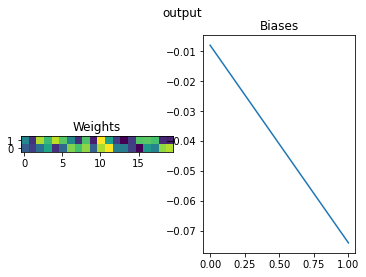

In [8]:
def create_model():
    model = MyNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    print(model)
    model.visualize_network()
    
    return model, criterion, optimizer, "Dummy_model"

t = wrapper.create_from_scratch(create_model, CrossEntropyTrainer, dl, dl_val, log_dir="test2")

In [10]:
x, labels = next(iter(dl))
print(x)
print(labels)
t.optimizer.zero_grad()
out = t.model(x)
print(out)
loss = t.criterion(out, labels)
print(loss)
loss.backward()
t.optimizer.step()    # Does the update

tensor([[  5.6814,  -7.7690,  -1.3367,   5.4579,   6.8985,   9.7428, -14.6739,
           7.0787,  -3.9874, -15.5740,  -7.6273, -15.3470,   0.3249],
        [ -9.5521,   9.1675,  -8.5350,  -2.6748,  -2.8291,  -8.1685,  11.8365,
          -8.6608,  15.2002,   6.9915,   9.0779,  -0.3651,   9.0542],
        [ -5.5911,  -8.6701,  -9.9221,  -6.5921,   7.7755,  -7.7217,   8.2898,
          12.1664,  19.0799,   1.6015,  -5.5160,   0.6950,   1.1279],
        [  9.3769,   6.9639,  -4.1354,  -0.7412,   1.7204,  -6.6689,  -8.3669,
          -9.0574,   2.3118,   4.4492,  -5.5608,  -2.1306,   5.4445],
        [ -3.6587,   4.6991,  -6.4998,   5.0791,   0.4033,  -3.2653,   7.5524,
          -7.1762,   1.3530, -14.9336,  -7.3010,   7.7950,   3.1543],
        [  5.7545,  -5.1768,  -3.3866,   9.5941,   0.8878,  -1.6535,  -1.3073,
           3.3813,   7.0512,  -5.0269,  -1.8195,   5.6127,   0.3163],
        [  2.7361,   9.7962,   9.7218,  -5.8429,  -5.9561,  -7.7332,  -5.5918,
         -13.1842, -16.0471

In [11]:
t.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

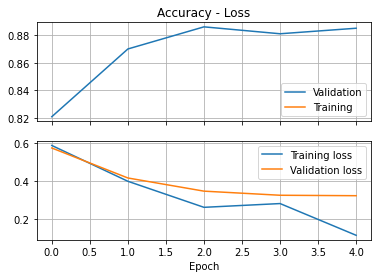

In [12]:
t.show_stats()

In [35]:
import pandas as pd
# Generate test sample
df = pd.DataFrame.from_records([v.to_record() for v in generate2d(10000)])

In [36]:
_ = df.pop("pi_y")
_ = df.pop("k_y")
#_ = df.pop("pi_z")
#_ = df.pop("k_z")
_ = df.pop("k_py")
_ = df.pop("pi_py")

In [37]:
def generate_continuous(number):
    for i in range(number):
        x = random.gauss(5, 1)
        y = random.gauss(5, 1)
        yield (x, y), (x*2, x*10)
        
data = []
labels = []
for d,l in generate_continuous(10000):
    data.append(d)
    labels.append(l)
    
ds = torch.utils.data.TensorDataset(torch.Tensor(data[:9000]), torch.Tensor(labels[:9000]))
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers=4, drop_last=True)
ds = torch.utils.data.TensorDataset(torch.Tensor(data[9000:]), torch.Tensor(labels[9000:]))
dl_val = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers=4, drop_last=True)

In [38]:
class MyNet2(DrawableNet):
    def __init__(self):
        super(MyNet2, self).__init__()
        self.hidden1 = nn.Linear(8, 40)
        self.hidden2 = nn.Linear(40, 30)
        self.hidden3 = nn.Linear(30, 10)
        self.output = nn.Linear(10, 2)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.sigmoid(self.hidden3(x))
        x = self.output(x)
        return x

    
def create_model2():
    model = MyNet2()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    print(model)
    model.visualize_network()
    
    return model, criterion, optimizer, "Dummy_model2"

In [47]:
ds = PandasDataSet(df.drop(columns="v_y").iloc[:9000], ['v_x', 'v_z'])
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers=4, drop_last=True)
ds = PandasDataSet(df.drop(columns="v_y").iloc[9000:], ['v_x', 'v_z'])
dl_val = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True, num_workers=4, drop_last=True)

MyNet2(
  (hidden1): Linear(in_features=8, out_features=40, bias=True)
  (hidden2): Linear(in_features=40, out_features=30, bias=True)
  (hidden3): Linear(in_features=30, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
)
Creating model at test4
  Name: Dummy_model2
Saving model in test4/Dummy_model2_3/model_Dummy_model2_3.pth


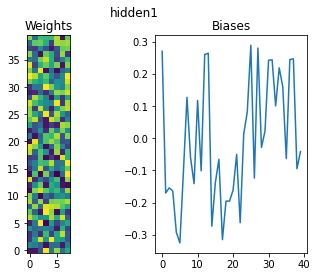

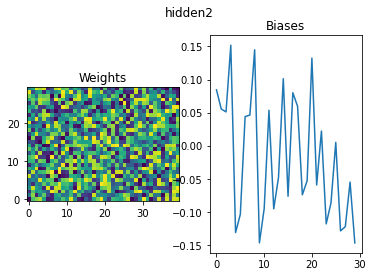

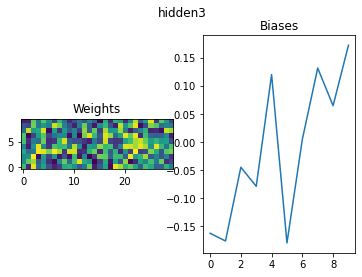

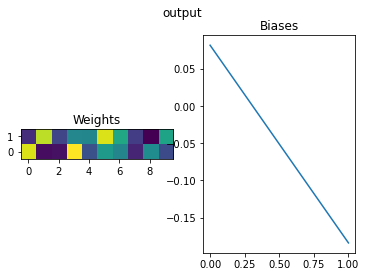

In [48]:
t = wrapper.create_from_scratch(create_model2, MyNonCrossEntropyTrainer, dl, dl_val, log_dir="test4")

In [49]:
x, labels = next(iter(dl))
print(x)
print(labels)
t.optimizer.zero_grad()
out = t.model(x)
print(out)
loss = t.criterion(out, labels)
print(loss)
loss.backward()
t.optimizer.step()    # Does the update

tensor([[ 6.1555e+02,  6.5898e+04, -1.5651e+01, -5.0000e+01,  2.1322e+04,
          3.8190e+04,  4.0617e+01,  1.0000e+02],
        [-3.0267e+03,  5.9670e+04, -4.3083e-01, -5.0000e+01,  2.3344e+04,
          3.9012e+04,  6.1822e+01,  1.0000e+02],
        [ 2.8108e+03,  7.7756e+04, -9.3180e-02, -5.0000e+01,  1.2082e+04,
          1.8616e+04,  7.5749e+01,  1.0000e+02],
        [ 3.7151e+03,  8.3495e+04, -7.8032e+00, -5.0000e+01,  1.0211e+04,
          1.8662e+04,  5.0316e+01,  1.0000e+02],
        [-3.2348e+02,  7.4353e+04, -5.3529e+00, -5.0000e+01,  2.2930e+04,
          4.0227e+04,  4.2238e+01,  1.0000e+02],
        [-4.4505e+03,  7.5739e+04,  2.0436e+01, -5.0000e+01,  2.3603e+04,
          4.1515e+04,  6.5068e+01,  1.0000e+02],
        [-2.1574e+03,  6.9489e+04, -3.0898e+00, -5.0000e+01,  2.6131e+04,
          4.0089e+04,  5.4827e+01,  1.0000e+02],
        [-6.4879e+02,  8.7334e+04,  5.2881e+00, -5.0000e+01,  2.6532e+04,
          4.5770e+04,  6.5736e+01,  1.0000e+02],
        [-1.3422

In [50]:
t.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

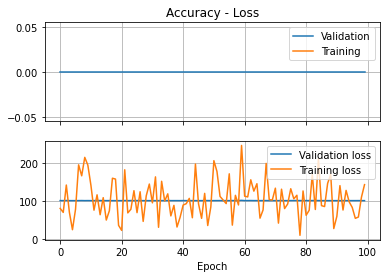

In [134]:
t.show_stats()